In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

from configs.config import Config, DataConfig, ModelConfig, TrainConfig
from src.datasets.droid_dataset import DroidDatasetIndexed as DroidDataset
from src.models.ddpm import DDPM

In [2]:
checkpoint_dir = "outputs/ddpm_50ep"
cfg = Config()


cfg.train = TrainConfig(
    **torch.load(os.path.join(checkpoint_dir, "trainer_config.pth"), weights_only=False)
)
cfg.model = ModelConfig(
    **torch.load(os.path.join(checkpoint_dir, "model_config.pth"), weights_only=False)
)
cfg.model.guidance_scale = 0.0
cfg.data = DataConfig(
    **torch.load(os.path.join(checkpoint_dir, "data_config.pth"), weights_only=False)
)

model = DDPM(cfg.model).to("cuda")
model.load_state_dict(
    torch.load(os.path.join(checkpoint_dir, "checkpoints/model_10.pth"))
)
model.eval()

DDPM(
  (unet): UNet(
    (unet_enc): ModuleList(
      (0): Sequential(
        (0): Conv2d(15, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Identity()
        (2): SiLU(inplace=True)
        (3): Dropout(p=0.0, inplace=False)
        (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Identity()
        (6): SiLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(44, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): Identity()
        (2): SiLU(inplace=True)
        (3): Dropout(p=0.0, inplace=False)
        (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): Identity()
        (6): SiLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1),

In [3]:
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    horizon=cfg.data.horizon,
    img_size=cfg.data.img_size,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

2025-05-03 20:56:40.002393: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 20:56:40.016332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746331000.033488 2232737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746331000.039338 2232737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746331000.054862 2232737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
data = next(iter(dataloader))
context_obs = data["context_obs"].cuda()
context_acts = data["context_acts"].cuda()
B = context_obs.shape[0]

context_obs = context_obs.view(B, -1, context_obs.shape[-2], context_obs.shape[-1])
context_acts = context_acts.view(B, -1)

samples = model.sample(
    context_acts=context_acts,
    context_obs=context_obs,
    num_steps=cfg.model.num_timesteps,
    img_wh=cfg.data.img_size,
    guidance_scale=None,
)

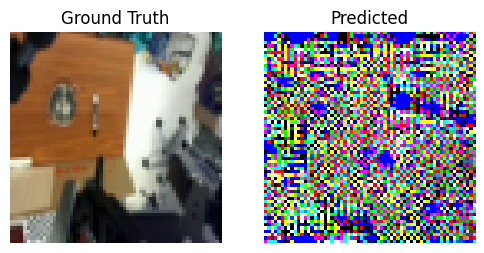

In [5]:
for i in range(min(B, 4)):
    pred_img = (samples[i].cpu().clamp(-1, 1) + 1) * 0.5
    gt_img = (data["obs"][i].cpu().clamp(-1, 1) + 1) * 0.5

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(to_pil_image(gt_img))
    axs[0].set_title("Ground Truth")
    axs[1].imshow(to_pil_image(pred_img))
    axs[1].set_title("Predicted")
    for ax in axs:
        ax.axis("off")
    plt.show()